In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('D:\Documents\Work\PSPH\Volumes\Data\\weekly volumes.csv')
df.head()

,Admit Week Date,End of Week Display Date,All Ministries,Alaska,NorCal,Oregon,Puget Sound,SoCal,Texas/NM,WA/MT
0,12/31/2017,1/6/2018,116661,4171,10160,29348,22181,28940,4664,17197
1,1/7/2018,1/13/2018,131198,4351,11206,35497,24924,30474,5069,19677
2,1/14/2018,1/20/2018,131382,4467,10085,37578,24304,30397,4876,19675
3,1/21/2018,1/27/2018,130872,4347,10449,36740,24295,29118,5112,20811
4,1/28/2018,2/3/2018,133769,4615,12048,34609,24187,32468,5718,20124


Text(0.5, 1.0, 'Patient Volumes by Region')

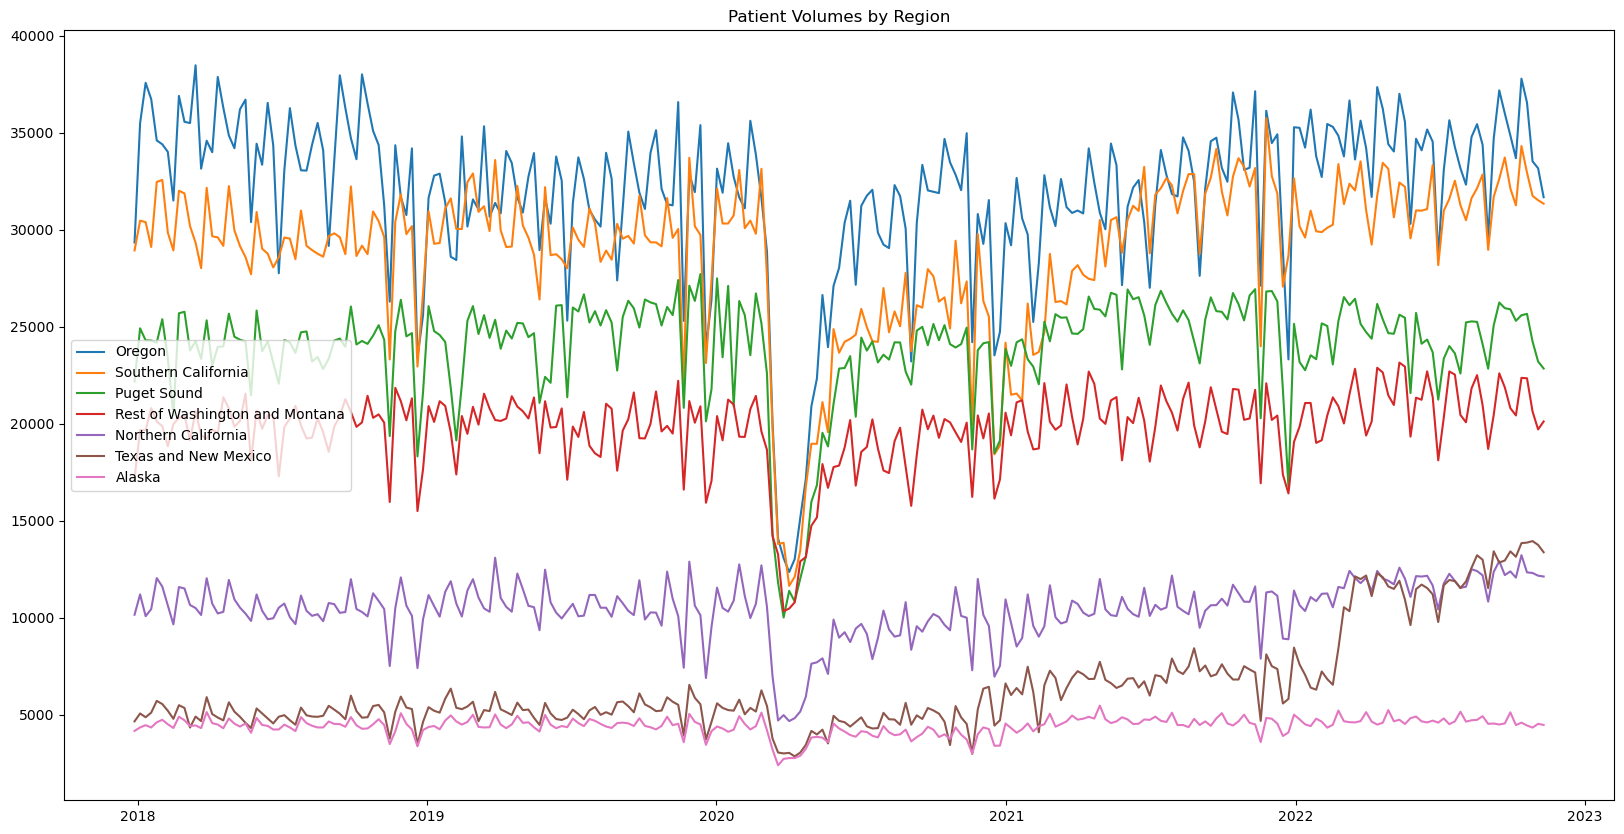

In [6]:
# one big plot of all regions
t = np.arange("2017-12-31", "2022-11-19", dtype = "datetime64[W]")
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(t, df['Oregon'], label = 'Oregon')
ax.plot(t, df['SoCal'], label = 'Southern California')
ax.plot(t, df['Puget Sound'], label = 'Puget Sound')
ax.plot(t, df['WA/MT'], label = 'Rest of Washington and Montana')
ax.plot(t, df['NorCal'], label = 'Northern California')
ax.plot(t, df['Texas/NM'], label = 'Texas and New Mexico')
ax.plot(t, df['Alaska'], label = 'Alaska')
ax.legend(loc = 'center left')
ax.set_title('Patient Volumes by Region')

Text(0.5, 1.0, 'Patient Volumes for Washington and Montana')

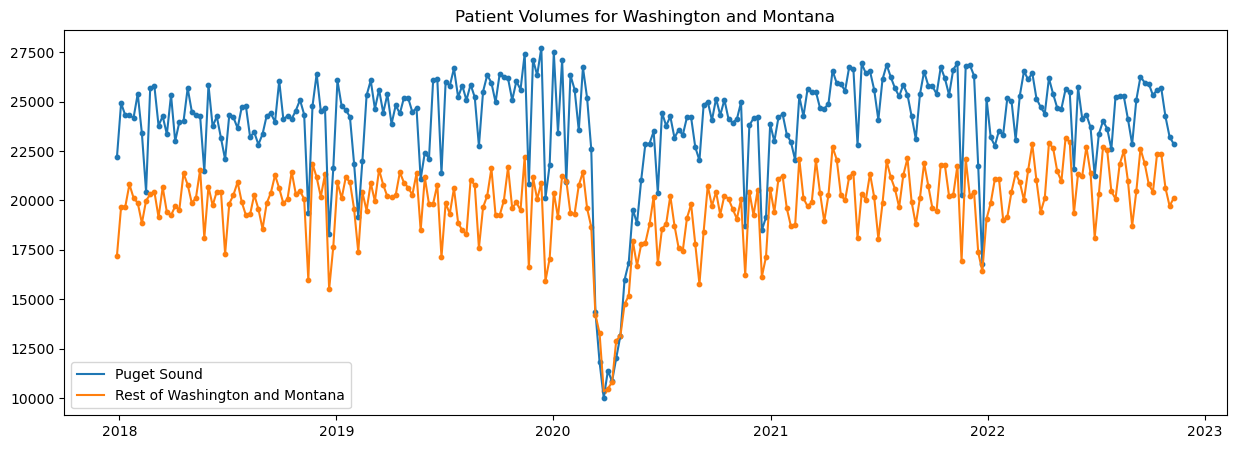

In [7]:
# plot of PS and WA/MT
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(t, df['Puget Sound'], label = 'Puget Sound')
ax.scatter(t, df['Puget Sound'], s = 10)
ax.plot(t, df['WA/MT'], label = 'Rest of Washington and Montana')
ax.scatter(t, df['WA/MT'], s = 10)
ax.set_title('Patient Volumes')
ax.legend(loc = 'lower left')
ax.set_title('Patient Volumes for Washington and Montana')

Some of the regions seem highly correlated. Lets examine the cross correlation of different regions

In [85]:
import statsmodels.api as sm

In [88]:
PS_WA = sm.tsa.stattools.ccf(df['Puget Sound'], df['WA/MT'], adjusted = False)
PS_WA[1:10]

array([0.54026578, 0.47731324, 0.41706963, 0.39591363, 0.35094303,
       0.22298724, 0.22028185, 0.16209486, 0.07077057])

The present value (lag 0) of WA/MT is moderately correlated (54%) with the patient volume of Puget Sound, and the correlation remains similarly high for subsequent weeks. The prior week volumes are correlated at 48%, decreasing slowly with each subsequent week. The fifth week delayed values are correlated at 35%, and by 9 weeks out the correlation is nearly 0. 

Next we will look at the feasibility of fitting a simple ARIMA model for the Puget Sound region.

In [108]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


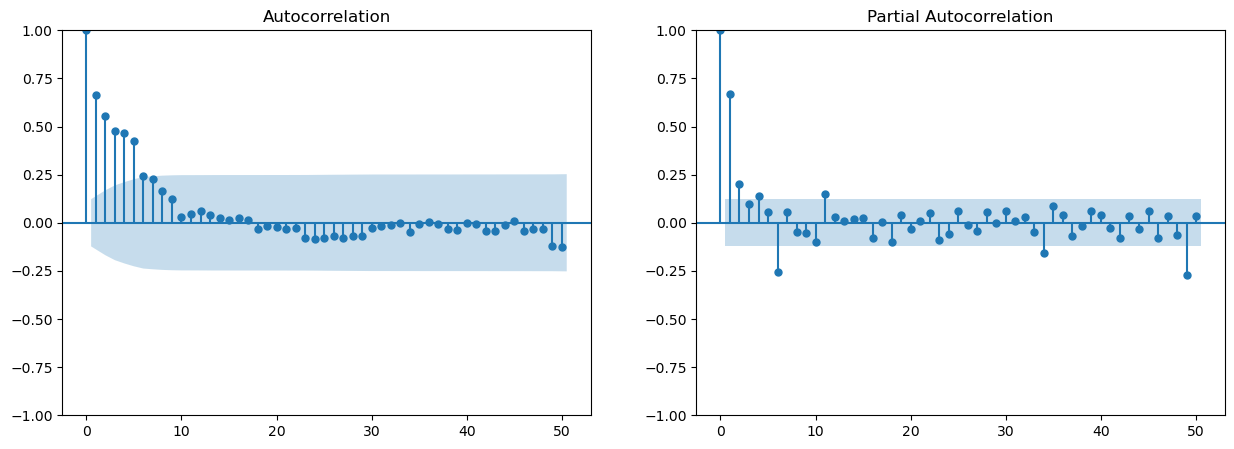

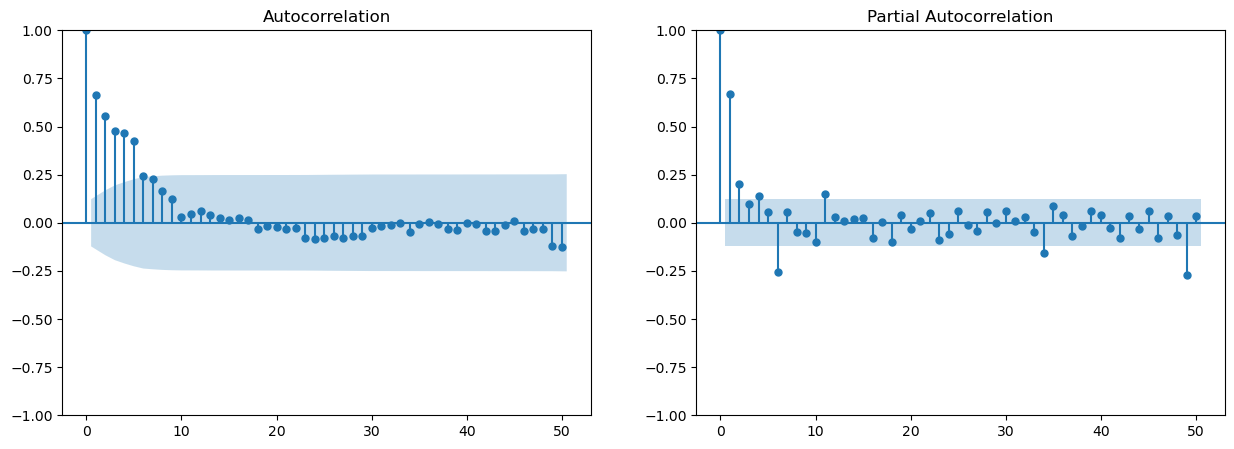

In [109]:
fig, axes = plt.subplots(1,2,figsize=(15,5), dpi= 100)
plot_acf(df['Puget Sound'], lags=50, ax=axes[0])
plot_pacf(df['Puget Sound'], lags=50, ax=axes[1])

Ignoring the 'always 1' 0th lag, we have 5 significant and decreasing first lags in the ACF and 2 in the PACF. Both MA and AR terms are warranted and we will attempt multiple model fits. There is no need to detrend, difference or account for seasonality.

In [146]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [226]:
# ARIMA(2,0,1) model
model = ARIMA(df['Puget Sound'], order = (2,0,1))
model1 = model.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:            Puget Sound   No. Observations:                  255
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2306.012
Date:                Mon, 05 Dec 2022   AIC                           4622.024
Time:                        14:38:46   BIC                           4639.730
Sample:                             0   HQIC                          4629.146
                                - 255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.394e+04    737.800     32.452      0.000    2.25e+04    2.54e+04
ar.L1          0.9639      0.245      3.936      0.000       0.484       1.444
ar.L2         -0.0841      0.169     -0.498      0.6

In [169]:
# ARIMA(1,0,1) model
model = ARIMA(df['Puget Sound'], order = (1,0,1))
model2 = model.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:            Puget Sound   No. Observations:                  255
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2306.217
Date:                Mon, 05 Dec 2022   AIC                           4620.434
Time:                        14:16:25   BIC                           4634.599
Sample:                             0   HQIC                          4626.132
                                - 255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.394e+04    716.256     33.428      0.000    2.25e+04    2.53e+04
ar.L1          0.8552      0.050     17.164      0.000       0.758       0.953
ma.L1         -0.3696      0.071     -5.196      0.0

In [223]:
# ARIMA(1,0,5) model
model = ARIMA(df['Puget Sound'], order = (1,0,5))
model3 = model.fit()
print(model3.summary())

                               SARIMAX Results                                
Dep. Variable:            Puget Sound   No. Observations:                  255
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -2295.629
Date:                Mon, 05 Dec 2022   AIC                           4607.259
Time:                        14:35:23   BIC                           4635.589
Sample:                             0   HQIC                          4618.654
                                - 255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.394e+04    601.846     39.783      0.000    2.28e+04    2.51e+04
ar.L1          0.5636      0.133      4.240      0.000       0.303       0.824
ma.L1         -0.0213      0.136     -0.157      0.8

In [ ]:
# residuals model 1
res = pd.DataFrame(model1.resid)
fig, ax = plt.subplots(1,2, figsize = (10,3))
res.plot(title="Residuals", ax=ax[0])
res.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The information criteria don't provide a clear consensus on which model is better. We can test the models performances on 'unseen' data by using it to predict values from any time in the series. Below we try to predict the most recent 5 weeks with an ARIMA(1,0,5) model, which had the lowest AIC, and an ARIMA(1,0,1) model, which had the lowest BIC.

In [245]:
# create 'training' and 'testing' set
train = df['Puget Sound'][:250]
test = df['Puget Sound'][250:]

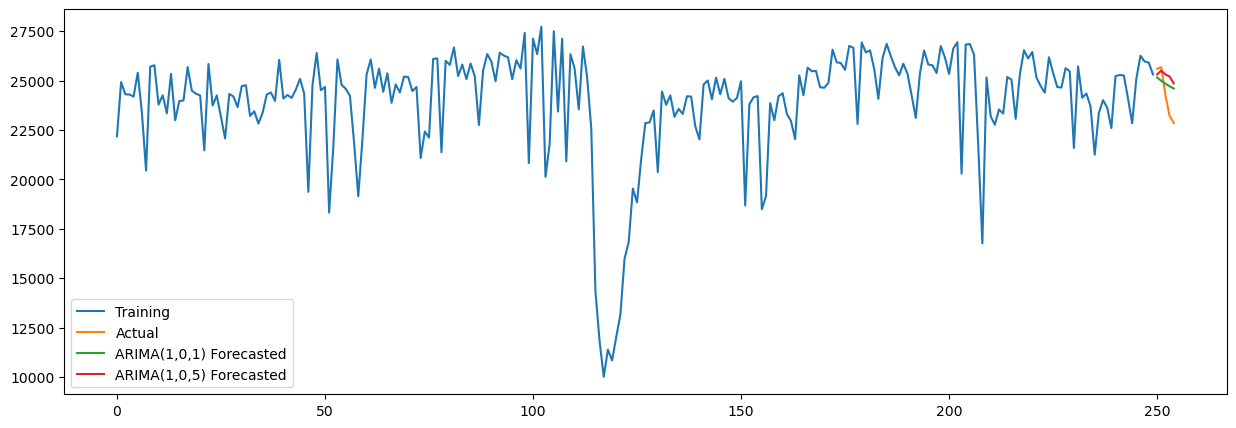

In [263]:
model2 = ARIMA(train, order = (1,0,1))
fits2 = model2.fit()
model3 = ARIMA(train, order = (1,0,5))
fits3 = model3.fit()

# forecast
fc2 = fits2.forecast(5)
fc2_series = pd.Series(fc2, index = test.index)
fc3 = fits3.forecast(5)
fc3_series = pd.Series(fc3, index = test.index)

# plot
plt.figure(figsize = (15,5))
plt.plot(train, label = 'Training')
plt.plot(test, label = 'Actual')
plt.plot(fc2_series, label = 'ARIMA(1,0,1) Forecasted')
plt.plot(fc3_series, label = 'ARIMA(1,0,5) Forecasted')
plt.legend()
plt.show()

We can test the accuracy of each model using Mean Absolute Percentage Error (MAPE) for all three models above.

In [280]:
def pred_acc(p, d, q, steps, split):
    train = df['Puget Sound'][:split]
    test = df['Puget Sound'][split:split+steps]
    model = ARIMA(train, order = (p,d,q))
    fits = model.fit()
    forecast = fits.forecast(steps)
    return(np.mean(np.abs(forecast - test.values)/np.abs(test.values))) # MAPE

mape_results = [0]*3
mape_results[0] = pred_acc(2,0,1,5,250)
mape_results[1] = pred_acc(1,0,1,5,250)
mape_results[2] = pred_acc(1,0,5,5,250)
print(mape_results)

[0.0424171600918939, 0.04175993726664069, 0.046997494509151735]


The ARIMA(1,0,1) model is most accurate in this sample. The most complicated (ARIMA(1,0,5)) is the worst, about 0.5% off the high mark. What about other periods of time? Which model performs best predicting the rise from the bottom of the Covid-19 related trough? This time we predict 10 time periods.

In [282]:
def time_testing(splittime):
    mape_results = [0]*3
    mape_results[0] = pred_acc(2,0,1,10,splittime)
    mape_results[1] = pred_acc(1,0,1,10,splittime)
    mape_results[2] = pred_acc(1,0,5,10,splittime)
    print(mape_results)
time_testing(118)

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[0.4001528359315327, 0.39268711459540745, 0.4517931928077298]


The simplest model is again the most accurate (not saying much, as it average an error of 39% during this period), but this time period is fairly simple, starting from the bottom of the absolute minimum and nearly only increasing. What about a few other times?

In [283]:
time_testing(95)

[0.10739404866234584, 0.10595001919800522, 0.10201409563677315]


In [289]:
time_testing(230)

[0.057775969891421065, 0.0570791532872435, 0.051504714208427324]


For both times the most complicated model is the most accurate, by about 0.6%. For most scenarios, the predictions from the three models will likely be together within this range.